In [1]:
# project imports
import sys
sys.path.append('/home/mark/Documents/code/drone/sumo/utils')
from runSumo import runSumo
from sumo_loop import sumo_loop

# general imports
import os
import subprocess
import numpy as np
import scipy.linalg
from mpl_toolkits.mplot3d import Axes3D
import pickle
import pandas as pd

# plotting params
from IPython.display import Math
# MATPLOTLIB
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib as mpl
from matplotlib.gridspec import GridSpec

# colors used
ORANGE_SCALE = ['#FFC999','#FFA04D','#FF7803']
NEW_SCALE = ['#FF9132','#008F00','#8A2BE2']
ORANGE = '#FF9132'
TEAL = '#0598B0'
GREEN = '#008F00'
PURPLE = '#8A2BE2'
GRAY = '#969696'
# FIG_WIDTH = 7
# FIG_HEIGHT = 4
FIG_WIDTH = 5
FIG_HEIGHT = 3.6
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "font.size": 8,
    "axes.titlesize": 10,
    "axes.spines.right": False,
    "axes.spines.top": False,
    "lines.linewidth": 2
})

For the experiments I simulated two variants of roads:

**(1) Two-Lane Road**
- 30 mph speedlimit    
- 500 meter road length
- 25 stops
- 1 hour long simulations

**(2) Three-Lane Road**
- 50 mph speedlimit    
- 2000 meter road length
- 100 stops
- 1.5 hour long simulations

**(2) Four-Lane Road**
- 50 mph speedlimit    
- 3000 meter road length
- 150 stops
- 1.5 hour long simulations

For all three roads I vary the **ratio** (truck flow:total flow) from **0.001 to 0.5** logarithmically. 

For road **(1)** I vary the total **flow** from **10 to 3000 veh/hour** in increments of 10

For road **(2)** I vary the total **flow** from **10 to 4500 veh/hour** in increments of 10

For road **(3)** I vary the total **flow** from **10 to 6000 veh/hour** in increments of 10

Flow is distributed so that the probability of a car **entering** the road from any lane is equivalant. Trucks on the other hand can choose the lane freely. This fixes some problems with SUMO forcing all cars to travel on the left lane, limiting their flow as each lane can only provide 1 car/sec. 


In [2]:
# Lets load in some of the simulations from the two lane road
sim_dir = {'2':'/media/mark/Ubuntu/results/new_drone/2_lane/',
           '3':'/media/mark/Ubuntu/results/new_drone/3_lane/',
           '4':'/media/mark/Ubuntu/results/new_drone/4_lane/'}

SAVE_PATHS = {'2':'/home/mark/Documents/drone/code/sumo/results/2_lane/',
              '3':'/home/mark/Documents/drone/code/sumo/results/3_lane/',
              '4':'/home/mark/Documents/drone/code/sumo/results/4_lane/'}

FINAL_SAVE = '/home/mark/Documents/latex/Drone_transC/figures/'
# sim_dir = {'2':'/home/mark/Documents/code/drone/analysis/2_lane/',
#            '3':'/home/mark/Documents/code/drone/analysis/3_lane/',
#            '4':'/home/mark/Documents/code/drone/analysis/4_lane/'}

ratios = np.logspace(np.log10(0.001),np.log10(0.1),100)
# flows = np.arange(10,5000,10) 

r_idxs = [0,99]
ratio = ratios[r_idxs]
# r_idxs = [1,2,3]
# ratio = [0.001,0.01,0.1]
ratio_plot = [str(r) for r in np.round(ratio,3)]
# ratio_plot = ['0.001','0.100']
print("ratios chosen: ",np.round(ratio,3))

# f_idxs = {'2':[100-1,200-1,300-2],'3':[200-1,300-1,400-2],'4':[300-1,400-1,500-2]}
# f_idxs = {'2':[100-1,200-1,300-2],'3':[200-1,300-1,400-2],'4':[300-1,400-1,500-2]}
# flow = {'2':[1000,2000,3000],'3':[2500,3500,4500],'4':[4000,5000,6000]}
# flow = {'2':[1000,2000,3000],'3':[1500,3000,4500],'4':[2000,4000,6000]}
# flow = {'2':[1000,2000,2670],'3':[1500,3000,4040],'4':[2000,4000,5300]}
flow = {'2':[1340,2000,2670],'3':[2020,3030,4040],'4':[2650,3980,5300]}
base_caps = {'2': 2670, '3': 4040, '4': 5300}
print("flows chosen: ",flow)

ratios chosen:  [0.001 0.1  ]
flows chosen:  {'2': [1340, 2000, 2670], '3': [2020, 3030, 4040], '4': [2650, 3980, 5300]}


In [3]:
# we can create some plot tools
# colors = ['y', ORANGE, 'r']
colors = ORANGE_SCALE
axs_key = {'2':0,'3':1,'4':2}
# title_key ={'2':'Two Lane Road Flow $\\frac{vehicles}{hour}$','3':'Three Lane Road Flow$\\frac{vehicles}{hour}$','4':'Four Lane Road Flow$\\frac{vehicles}{hour}$'}
title_key ={'2':'Two lane road flow \n($\\%$ of $f^0$)','3':'Three lane road flow\n ($\\%$ of $f^0$)','4':'Four lane road flow\n ($\\%$ of $f^0$)'}
ratio_title ={'2':'Two Lane Road','3':'Three Lane Road','4':'Four Lane Road'}

# flow_axs = {'2':[0,1000,2000,2636,3000],'3':[1500,2500,3500,3930,4500],'4':[3000,4000,5000,5264,6000]}
# flow_axs_lim = {'2':[0,3000],'3':[1500,4500],'4':[3000,6000]}
# flow_axs = {'2':[0,1000,2000,base_caps['2'],3000],'3':[0,1500,3000,base_caps['3'],4500],'4':[0,2000,4000,base_caps['4'],6000]}
flow_axs = {'2':[670,1340,2000,2670],'3':[1010,2020,3030,4040],'4':[1330,2650,3980,5300]}
flow_axs_lim = {'2':[0,3000],'3':[0,4500],'4':[0,6000]}
annotation_y = {'2':150,'3':-80,'4':-100}
arrow_y = {'2':200,'3':0,'4':0}

x_shifts = {'2':50,'3':200,'4':250}

For each ratio and flow pair, we look at the arrival times (arrival = left the road) of **all vehicles** throughout the simulation. 

Since the **flow-in** of traffic is **constant during the first hour** of simulation, I expect the road to be most resemblent of **steady state**  during the middle of this timeframe. Hence to calculate the flow on (out) the road, **I divide the total number of arrivals between the 15 minute mark and the 45 minute mark by 30 minutes.** 

To better visualize what is going on, below I show what happens when I window the arrival rates (# of arrivals at time t) by 30 minutes throughout the entire simulation. The point at **t=30 minutes** represents the **steady state flow out.**

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


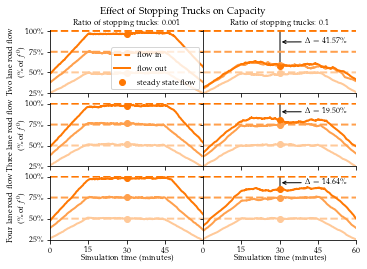

In [4]:
import matplotlib.ticker as mtick

fig = plt.figure(figsize=(FIG_WIDTH,FIG_HEIGHT))
widths = np.ones_like(ratio)/len(ratio)
heights = [0.33,0.33,0.33]
spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths,
                        height_ratios=heights,
                        left=0.13,
                        bottom=0.08,
                        right=0.98,
                        top=0.89)

spec.update(wspace=0, hspace=0.15)
N_smooth = 1800 # 30 minute window

# for key in sim_dir.keys():
for key in ['2','3','4']:
    for idx_r in range(len(ratio)):
        # Plot Setup
        axs = fig.add_subplot(spec[axs_key[key],idx_r])
        axs.yaxis.set_major_formatter(mtick.PercentFormatter(base_caps[key]))
        # axs.set_ylim(flow_axs_lim[key])
        axs.set_ylim([flow_axs[key][0],base_caps[key]+40])
        axs.set_xlim([0,60])

        if key == '2':
            axs.set_title('Ratio of stopping trucks: %s'%(ratio_plot[idx_r]), fontsize=8)
            axs.set_xticks([0,15,30,45])
            if idx_r==1:
                axs.set_xticks([0,15,30,45,60])
            axs.set_xticklabels([])
        elif key == '3':
            axs.set_xticks([0,15,30,45])            
            if idx_r==1:
                axs.set_xticks([0,15,30,45,60])
            axs.set_xticklabels([])
        elif key == '4':
            axs.set_xlabel('Simulation time (minutes)',labelpad=-0.7)   
            axs.set_xticks([0,15,30,45])
            if idx_r==1:
                axs.set_xticks([0,15,30,45,60])
            
        if idx_r == 0:
            axs.set_ylabel(title_key[key],labelpad=-1)
            axs.set_yticks(flow_axs[key])
        if idx_r != 0:
            axs.set_yticks(flow_axs[key])
            axs.set_yticklabels([])    

        # --------------------------------- #
        for idx_f in range(len(flow[key])):
            # data loading
            outfile = sim_dir[key] + str(r_idxs[idx_r]) + '/' + str(flow[key][idx_f]) + '/outfile.csv'
            df = pd.read_csv(outfile, delimiter=';')
            # get arrival times
            arrival = df.tripinfo_arrival
            time = np.arange(start=0,stop=max(arrival)+1)
            flow_out = np.zeros(int(max(arrival))+1)
            # measure and smooth the flow out
            for t in arrival:
                flow_out[int(t)] += 1
            smooth_flow = np.convolve(flow_out,np.ones(N_smooth)/N_smooth,mode='same')[x_shifts[key]:-1]
            time = time[0:len(time)-x_shifts[key]-1]
            # plot it
            if key == '2' and idx_r == 0 and idx_f == 2 :
                axs.plot(time/60, np.ones_like(smooth_flow)*flow[key][idx_f],linestyle='dashed', label='flow in', color=colors[idx_f])
                axs.plot(time/60, smooth_flow*3600, label='flow out', color=colors[idx_f]) # scaled to  be in hours
                axs.scatter(time[1800]/60,smooth_flow[1800]*3600,label='steady state flow', color=colors[idx_f])
            else:
                axs.plot(time/60, smooth_flow*3600, color=colors[idx_f]) # scaled to  be in hours
                axs.scatter(time[1800]/60,smooth_flow[1800]*3600, color=colors[idx_f])
                axs.plot(time/60, np.ones_like(smooth_flow)*flow[key][idx_f],linestyle='dashed', color=colors[idx_f])
        # --------------------------------- #
        # ^^ FINISHED PLOTTING LINES #
        # # plot max capacity
        if key == '2' and idx_r == 0 and idx_f == 2 :
        #     axs.plot(time/60, np.ones_like(smooth_flow)*base_caps[key],linestyle='solid', label='capacity w/o trucks', color=TEAL)
            axs.legend(loc=4)
        # else:
        #     axs.plot(time/60, np.ones_like(smooth_flow)*base_caps[key],linestyle='solid', color=TEAL) 
        # print(max_cap)
        # post process annotation
        if idx_r!=0:
            x = x=time[1800]/60
            ymin = smooth_flow[1800]*3600
            ymax = base_caps[key]
            delta = 100*((ymax-ymin)/ymax)
            # axs.axvline(x=x,ymin=ymin/flow_axs_lim[key][1],ymax=ymax/flow_axs_lim[key][1],color='gray',zorder=0)
            axs.axvline(x=x,ymin=ymin/(base_caps[key]+500),ymax=ymax/(base_caps[key]+60),color='gray',zorder=0)
            # axs.annotate('Intersection', xy=(x,np.mean(ymin,ymax)), xytext=(x+5,np.mean(ymin,ymax)),arrowprops=dict(arrowstyle="->"),fontsize=12)

            axs.annotate('$\\Delta=%.2f$'%delta+'$\\%$', xy=(x,((ymin+ymax)/2)+arrow_y[key]), xytext=(x+10,((ymin+ymax)/2)+annotation_y[key]),arrowprops=dict(arrowstyle="->"),fontsize=8)
# plt.show()
fig.suptitle('Effect of Stopping Trucks on Capacity',fontsize=10)
bbox = mpl.transforms.Bbox([[0,0],[FIG_WIDTH,FIG_HEIGHT]])

plt.savefig('/home/mark/Documents/code/drone/sumo/results/figures/'+'sumo_cap' + '.pdf',bbox_inches=bbox)
plt.savefig('/home/mark/Documents/code/drone/sumo/results/figures/'+'sumo_cap' + '.png',bbox_inches=bbox)

plt.savefig(FINAL_SAVE+'sumo_cap' + '.pdf',bbox_inches=bbox)
plt.savefig(FINAL_SAVE+'sumo_cap' + '.png',bbox_inches=bbox)



In [5]:
# THRESHOLD = 100
# # PERCENT = 0.03
# caps = {}
# for key in ['2','3','4']:
#     data = pickle.load(open(SAVE_PATHS[key]+'capacity.p','rb'))
#     ratios = data['ratios']
#     flows = data['flows']
#     capacity = data['capacity']
    
#     inner_caps = []
#     for i in range(len(ratios)):    
#         # check_cap = (flows-capacity[i,:])>(flows*PERCENT)
#         check_cap = (flows-capacity[i,:])>THRESHOLD
#         for cap_idx in range(len(check_cap)-1,-1,-1):
#             if check_cap[cap_idx] == False:
#                 inner_caps.append(flows[cap_idx])
#                 break
#     caps[key] = inner_caps
#     base_caps[key] = inner_caps[0]
# print(base_caps)

In [6]:
# fig = plt.figure(figsize=(9,9))
# widths = [0.33,0.33,0.33]
# heights = [0.33,0.33,0.33]
# spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths,
#                         height_ratios=heights,
#                         left=0.1,
#                         bottom=0.16,
#                         right=0.98,
#                         top=0.9)

# spec.update(wspace=0.1, hspace=0.1)

# for key in ['2','3','4']:
#     data = pickle.load(open(SAVE_PATHS[key]+'capacity.p','rb'))
#     ratios = data['ratios']
#     flows = data['flows']
#     capacity = data['capacity']

#     for i in range(len(ratio)):    
#         axs = fig.add_subplot(spec[axs_key[key],i])
#         axs.set_title("r: %.5f"%ratio[i])
#         axs.set_xlabel('flow in')
#         # p flow in vs flow out
#         axs.plot(flows,flows,linestyle="dashed")
#         axs.plot(flows,capacity[r_idxs[i],:])
#         # axs[i].plot(flows,np.ones_like(flows)*np.max(r_vs_f[r_idxs[i],:]),linestyle='dashed')
#         estimate = caps[key][r_idxs[i]]
#         axs.plot(flows,np.ones_like(flows)*estimate,linestyle='dashed')
# plt.show()


In [7]:
# r_idxs = [0,98]
# fig = plt.figure(figsize=(9,4))
# widths = [0.33,0.33,0.33]
# heights = [1]
# spec = fig.add_gridspec(ncols=len(widths), nrows=len(heights), width_ratios=widths,
#                         height_ratios=heights,
#                         left=0.1,
#                         bottom=0.16,
#                         right=0.98,
#                         top=0.9)

# spec.update(wspace=0.1, hspace=0.1)

# for i in range(len(r_idxs)): 
#     axs = fig.add_subplot(spec[0,i])
#     if i == 0:
#         axs.set_ylabel('flow out')
#     axs.set_title("r: %.3f"%ratios[r_idxs[i]])
#     axs.set_xlabel('flow in')
#     # p flow in vs flow out
#     axs.plot(flows/base_caps[key],flows/base_caps[key],linestyle="dashed")
#     axs.set_xlim([0.4,1.2])
#     axs.set_ylim([0.4,1.2])

#     for key in ['2','3','4']:
#         data = pickle.load(open(SAVE_PATHS[key]+'capacity.p','rb'))
#         ratios = data['ratios']
#         flows = data['flows']
#         capacity = data['capacity']
    
#         axs.plot(flows/base_caps[key],capacity[r_idxs[i],:]/base_caps[key],color=NEW_SCALE[axs_key[key]])
#         axs.plot(np.asarray(flows)/base_caps[key],np.ones_like(flows),linestyle='dashed')
#         estimate = caps[key][r_idxs[i]]
#         # axs.plot(flows/flows,np.ones_like(flows)*estimate,linestyle='dashed')    #     axs.plot(flows,capacity[r_idxs[i],:])

# plt.show()
